In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# NCL stuff:
#import Ngl, Nio
import Nio
#import pyncl
#
import pylab as plt
import numpy
#import scipy
#
import os,sys
#import pathlib

import getpass
import subprocess
import contextlib

def file_report(fin):
    dims = fin.dimensions.values()
    dimnames = fin.dimensions.keys()
    #
    varnames_all = fin.variables.keys()
    varnames = [s for s in varnames_all if not s in dimnames]
    #
    print('** dims: ', list(zip(dimnames, dims)))
    #
    print('** varnames_all: ', varnames_all)
    print('** varnames: ', varnames)
    #

    print('type(fin.dimensions): ', type(fin.dimensions) )
    #
    return None


### Mount network resource (sshfs), if we are working locally
- This only if we want to pull down a (small) subset of data to our local machine
- use subprocess() to mount the remote FS
- Note we do * **not** * write our password in code, pull it from a (n unencrypted) data file, etc. In fact, in this script, we don't even write it to a variable
- If working on a tool server, etc. this drive will (probable) already be mounted.


In [7]:
#do_mount = True
do_mount = False
#
f_mount_out='/scratch'
f_mount_in='/data'
print('** fmount_out: {}'.format(f_mount_out))
print('** fmount_in: {}'.format(f_mount_in))
#
mazama_umount_data = 'umount {} && umount {}'.format(f_mount_in, f_mount_out)
#
#
if do_mount:
    f_mount_in = os.path.join(os.environ['HOME'], 'mazama_data')
    print('** fmount_in: {}'.format(f_mount_in))
    f_mount_out = os.path.join(os.environ['HOME'], 'mazama_scratch')
    print('** fmount_out: {}'.format(f_mount_out))



    #
    # this should work, in principle, but it is not (so far), and maybe for good reasons. I've definitely
    #. read taht using the -o password_stdin option sometimes does not work.
    #ssh_password = getpass.getpass('ssh password: ')
    #
    # sshfs cees-tool-7:/data ~/mazama_data -o password_stdin -o volname=mazama_data <<<
    #
    # set up sshfs call here...source
    mazama_mount_data_in = 'sshfs cees-tool-7:/data {} -o password_stdin -o volname=mazama_data <<< {}'
    mazama_mount_data_out = 'sshfs cees-tool-7:/scratch {} -o password_stdin -o volname=mazama_scratch <<< {}'
    #
    #
    #subprocess.call(mkdir_command, shell=True)
    subprocess.call(mazama_mount_data_in.format(f_mount_in, getpass.getpass()), shell=True)
    subprocess.call(mazama_mount_data_out.format(f_mount_out, getpass.getpass()), shell=True)
    #
    #del ssh_password
    #source
    print('ls f_mount: \n', os.listdir(f_mount))



** fmount_out: /scratch
** fmount_in: /data


In [10]:
# NOTE: probably need to connect (sshfs) to NFS (sshfs cees-tool-7:/data {f_mount})
input_file_path = 'ESS/regirock/cesm_archive/Rachel/U_V_T_Z3_plWACCMSC_CTL_122.cam.h2.0001-0202.nc'

input_file_path = os.path.join(f_mount_in, input_file_path)
#
#output_file_path = 'my_output.nc'
#output_file_path = os.path.join(os.environ['HOME'], 'Codes/temp/my_output.nc')
output_file_path = os.path.join(f_mount_out, 'yoder/my_output.nc')
if not os.path.isdir(os.path.split(output_file_path)[0]):
    os.makedirs(os.path.split(output_file_path)[0])
#
#input_file_path = os.path.join(os.environ['HOME'], input_file_path)

#
print('** pth_name: {}'.format(input_file_path))

#
#
# # we can also use pathlib to construct the path, but it does not really gain us much.
# #  nominally, we should construct the path from an orderd list of parts ['mazama_data', 'ESS', ...]
# #. and then .join() them, in the event that sommebody tries this from Windows. But for now,
# #. we'll let Windows usiers fix it themselves (if need be)...
#
# TODO: reorganize using a context manager. Nio.open_file() will not take a CM directly, but we 
#. can make one using contextlib:
# with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
#.  etc...
#.  etc...
# open the file; use a context handler:
# ... or maybe not. seems to not be compatible...
#
#fin = Nio.open_file(input_file_path, 'r')
#

** pth_name: /data/ESS/regirock/cesm_archive/Rachel/U_V_T_Z3_plWACCMSC_CTL_122.cam.h2.0001-0202.nc


### Data properties
- We've opend a data file handle...
- Now, let's look at some properties of the data set:
    - dimension and dimension names
    - Note that rank is the size of the dimensions array (dimensions of dimensions)
    - Note also the distinction between dimensions and variables. 
    - From a strict data-modeling standpoint, this is sort of silly, but it makes sense that it is the minimum (maximum?) level of slicing. After the dimensions, are attributes that group together... sort of.
   - And some additional diagnostics 
   

In [11]:
with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
    file_report(fin)
    #
    print('##############')
    # note that the lat and lon variables are small (they are basically just indices):
    lats = fin.variables['lat']
    lons = fin.variables['lon']
    #p_levs = fin.variables['lev_p']
    p10 = fin.variables['lev_p'][2]
    #
    print('lats: ', [y for y in lats])
    print('lons: ', [x for x in lons])
    print('p10: ', p10)
    tm   = fin.variables['time']
    print('len(time): ', len(tm))
    #print('p_levs: ', [p for p in p_levs])

** dims:  [('time', 73730), ('lev_p', 13), ('lat', 96), ('lon', 144)]
** varnames_all:  dict_keys(['U', 'time', 'lev_p', 'lat', 'lon', 'V', 'Z3', 'T', 'PV'])
** varnames:  ['U', 'V', 'Z3', 'T', 'PV']
type(fin.dimensions):  <class 'dict'>
##############
lats:  [-90.0, -88.10526315789474, -86.21052631578948, -84.3157894736842, -82.42105263157895, -80.52631578947368, -78.63157894736842, -76.73684210526316, -74.84210526315789, -72.94736842105263, -71.05263157894737, -69.15789473684211, -67.26315789473685, -65.36842105263158, -63.473684210526315, -61.578947368421055, -59.684210526315795, -57.78947368421053, -55.89473684210527, -54.0, -52.10526315789474, -50.21052631578947, -48.31578947368421, -46.42105263157895, -44.526315789473685, -42.631578947368425, -40.73684210526316, -38.8421052631579, -36.94736842105264, -35.05263157894737, -33.15789473684211, -31.263157894736842, -29.368421052631582, -27.473684210526322, -25.578947368421055, -23.684210526315795, -21.789473684210535, -19.894736842105

### Subsetting the raw data
- Open the raw/source data file (already done!)
- Take some 'slice' of our variable of interest

In [14]:
with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
    # TODO: set up batching, and see if we can use a += syntax when we write to the output file.
    batch_size = 100
    udum = fin.variables['U'][0:batch_size, 2,:,:]
    # we can get a second (subsequent) slice like this:
    udum2 = fin.variables['U'][len(udum):len(udum)+batch_size, 2,:,:]
    #
    print('udum: ')
    print(len(udum))
    print('** ', udum.shape)
    #
    #
    print('udum2: ')
    print(len(udum2))
    print('** ', udum2.shape)
    #

udum: 
100
**  (100, 96, 144)
udum2: 
100
**  (100, 96, 144)


Any actual data in those sequences?


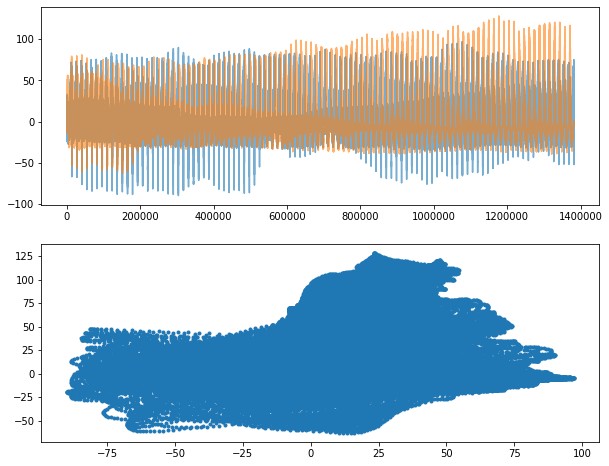

In [15]:
print('Any actual data in those sequences?')
#print('** ', udum[0:10])
#print('** ', udum2[0:10])
#
fg = plt.figure(figsize=(10,8))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
#
ax1.plot(numpy.ravel(udum), ls='-', marker='', alpha=.6)
ax1.plot(numpy.ravel(udum2), ls='-', marker='', alpha=.6)
#
ax2.plot(numpy.ravel(udum), numpy.ravel(udum2), marker='.', ls='')

### Export a subset of the data or a derived data set:
- Create a file for export
- Note that there are good and bad ways to do this (usually trading code complexity for speed)
- For optimal speed, we pre-define as much of the output as possible
- For simplicity, we might leave our principal dimension undefined -- or something like that.
- Note: we can open our file in modes; {'c': create,'r': read, {'w', 'r+', 'a', ???}: read+, append, write} 

#### What We are Going to Do:
- Create the output file
- Discuss in comments some file-writng methods, strategies, etc.
- Then do the file writing (exporting) in the following pane.


In [20]:
# create the file. define everything!
#
#
#
os.system('rm {}'.format(output_file_path))
# do we need to delete the file?
with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
    # time dimension size:
    # we can get the full dimension size, if we are going to write the whole lot;
    # otherwise, maybe just a subset?
    n_time = fin.dimensions['time']
    #
    # if we were batching, we might do something like this:
    # assume we'll take 10 iterations (or so)
    #n_batches = 10
    #n_time = n_batches*batch_size
    #
    with contextlib.closing(Nio.open_file(output_file_path, 'c')) as fout:
        #fout = Nio.open_file(output_file_path, 'c')
        fout.create_dimension('time', n_time)
        fout.create_dimension('lat', fin.dimensions['lat'])
        fout.create_dimension('lon', fin.dimensions['lon'])
        #
        # set the dimension variable values as well:
        # NOTE: this step may not be necessary; these variables might be brought along by
        #. the principal data, since those data have lat, lon, time listed as their dimensions.
        for v_name in ('lat', 'lon', 'time'):
            fout.create_variable(v_name, 'f', (v_name, ) )
            fout.variables[v_name][:] = fin.variables[v_name]
        #
        fout.create_variable('U','f',('time','lat','lon'))
        setattr(fout.variables['U'], 'standard_name', 'pressure')
        setattr(fout.variables['U'], 'units', 'kPa')
        #
        # NOTE: the .set_value() syntax is required for scaler, non-indexed values (or so I have read).
        #. we can also use it for arrays, but only if we are assigning the whole value -- in other words, the 
        #. dimensinos must match. (this works if dim(udum)==dim(fout)). I assume the exception is if the output
        #. dimension is undefined.
        #
        #fout.variables['u'].assign_value(udum)        # this works if dimensions align
        #fout.variables['u'][0:len(udum)] = udum      # use this for partial assignment (note, i think this does allow 
        #                                            # (aka, will expand) for overflow -- [k,j] > len(fout.variable) )
        #
        # if this is going to take a long time, it might be smart to close and explicitly bufer.

        #
        # and we might want to close the file here:
        print('file created: ')
        print(file_report(fout))
        #fout.close()
    #

file created: 
** dims:  [('time', 73730), ('lat', 96), ('lon', 144)]
** varnames_all:  dict_keys(['lat', 'lon', 'time', 'U'])
** varnames:  ['U']
type(fin.dimensions):  <class 'dict'>
None


In [21]:
# check our work. What have we written?
with contextlib.closing(Nio.open_file(output_file_path, 'r')) as fin_check:
    print('Some File Info: {}'.format(output_file_path))
    print(file_report(fin_check))
    #
    fin_check.close()

Some File Info: /scratch/yoder/my_output.nc
** dims:  [('time', 73730), ('lat', 96), ('lon', 144)]
** varnames_all:  dict_keys(['lat', 'lon', 'time', 'U'])
** varnames:  ['U']
type(fin.dimensions):  <class 'dict'>
None


### Writing to the file
- Our basic operation is:
    - Read a batch of data from the source file (fin)
    - Do whatever we need to do to said data
    - Write something (in this case, just the data) to the output file
- We have soeme choices:
    - Buffer to a memory variable (aka, read into a local memory variable, then write that variable to output)
    - Internal buffers only (fout.variables[my_var_out][k:j] = fin.variables[my_var_in][l:m] )
        - For simple data transfers, this is probaby the best approach. In fact, we can probably skip batching, since the NetCDF objects are probably smart enough to manage memory.
    - Parallelization: 
        - Depending on where latency occurs, etc., there may be opportunity to speed this up via reading and writing in parallel channels. Basically, run separate threads over a set of index ranges.
        - Also, for simple filering or processing, the data transfer may be slow enough that it would make sense to parallelize the read/process steps (aka, extract a batch; submit to a processing thread, extract the next bit).


In [ ]:
with contextlib.closing(Nio.open_file(output_file_path, 'a')) as fout:
    fout.variables['U'][:] = fin.variables['U'][:, 2,:,:]

#### Batching:
- This is how to batch the write job
- But we will probably just let Nio figure out how to best do that
- ...unless we decide to parallelize, in which case we'll do something similar to this
- ...but before we do that, we want to be sure that it will actually help.

In [25]:
# First, demonstrate read/write with batches. It will be important to understand how to do this if we ever want
#. to do something more complicated that a straight transfer or simple filter.
# note: we don't need the same batch sizes:
batch_size_write = 2000
n_batches = int(numpy.ceil(n_time)/batch_size_write)
#
print('*** writing {} batches, of size {} (last batch might be smaller)'.format(n_batches, batch_size_write))

*** writing 36 batches, of size 2000 (last batch might be smaller)


In [ ]:
#
# fib should already be open:
#fin = Nio.open_file(input_file_path, 'r')

#
with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
    #
    with contextlib.closing(Nio.open_file(output_file_path, 'a')) as fout:
        # 'a', 'w', 'r+' all mean (read, write/append)
        #
        # extract data like: udum = fin.variables['U'][0:batch_size, 2,:,:]
        for j,k in enumerate(range(0, n_time, batch_size_write)):
            #print('** ** [{}:{}]'.format(k, k+batch_size_write))
            #
            # remember, our read-data are like:
            # udum = fin.variables['U'][0:batch_size, 2,:,:]
            # and we're making out output file more or less a mirror of that:
            # note: we never explicilty store the data in a local variable; the memory footprint
            #. is determined entirely by the NetCDF class, so really we can probably do this in one batch...
            #  unless we want to parallelize, in which case we can run each of thsed batches an a Process() thread,
            # in a Queue(), Pool(), etc.
            print('begin k={}/{} batches [{}:{}]/{}.'.format(j, n_batches, k, k1, n_time))
            k1 = min(k+batch_size_write, n_time)
            fout.variables['U'][k:k1] = fin.variables['U'][k:k+batch_size_write, 2,:,:]


begin k=0/36 batches [0:0].
begin k=1/36 batches [2000:2000].
begin k=2/36 batches [4000:4000].
begin k=3/36 batches [6000:6000].
begin k=4/36 batches [8000:8000].
begin k=5/36 batches [10000:10000].
begin k=6/36 batches [12000:12000].
begin k=7/36 batches [14000:14000].
begin k=8/36 batches [16000:16000].
begin k=9/36 batches [18000:18000].
begin k=10/36 batches [20000:20000].
begin k=11/36 batches [22000:22000].
begin k=12/36 batches [24000:24000].
begin k=13/36 batches [26000:26000].
begin k=14/36 batches [28000:28000].
begin k=15/36 batches [30000:30000].
begin k=16/36 batches [32000:32000].
begin k=17/36 batches [34000:34000].
begin k=18/36 batches [36000:36000].
begin k=19/36 batches [38000:38000].
begin k=20/36 batches [40000:40000].
begin k=21/36 batches [42000:42000].
begin k=22/36 batches [44000:44000].
begin k=23/36 batches [46000:46000].
begin k=24/36 batches [48000:48000].
begin k=25/36 batches [50000:50000].
begin k=26/36 batches [52000:52000].


### Reading, writing in parallel:
- Note that we should not expect to see any improvement on this if the NetCDF backend(s) do not support parallel IO, but it's worth a try.


In [ ]:
#
n_cpu=8
P = mpp.Pool(n_cpu)
#
# we don't actually need to return anything from the chile processes (except maybe an error code),
# so which Pool() function do we use (or shold we use a Queue() ?)?
#. - map_async()
#. - apply_async()
#. (I'm pretty sure that "map" is just useless, since I think it runs in serial?)
with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
    #
    with contextlib.closing(Nio.open_file(output_file_path, 'a')) as fout:
        # 'a', 'w', 'r+' all mean (read, write/append)
        #
        # extract data like: udum = fin.variables['U'][0:batch_size, 2,:,:]
        for j,k in enumerate(range(0, n_time, batch_size_write)):
            #print('** ** [{}:{}]'.format(k, k+batch_size_write))
            #
            # remember, our read-data are like:
            # udum = fin.variables['U'][0:batch_size, 2,:,:]
            # and we're making out output file more or less a mirror of that:
            # note: we never explicilty store the data in a local variable; the memory footprint
            #. is determined entirely by the NetCDF class, so really we can probably do this in one batch...
            #  unless we want to parallelize, in which case we can run each of thsed batches an a Process() thread,
            # in a Queue(), Pool(), etc.
            print('begin k={}/{} batches.'.format(j, n_batches))
            fout.variables['U'][k:k+batch_size_write] = fin.variables['U'][k:k+batch_size_write, 2,:,:]
